1. Benchmark Events
- Auswahleverteilung iN und hN darstellen für Train, Validation und Test daten
2. MSE für Train, Val und Test vergleichen
3. R² (Squared Error) Verteilung für alle ergebnisse
- Boxplot oder Violinenplot
4. Actual vs Fitted
5. MSE der Maximalwerte jedes Ereignisses aus Testdatensatz
- (Zeitliche Verschiebung des Maximalwertes)
6. Stichproben Plots von Maximalwerten 


In [7]:
# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler
from modules.plots import plot_seq_i_d_Q
from modules.save_load_model import load_model
from modules.extract_sim_data import multi_node
from sklearn.model_selection import train_test_split


# Load the model
model_folder = os.path.join('05_models', 'Gievenbeck_LSTM_Single_1h_P_20240408')
# model_folder = os.path.join('05_models', 'Gievenbeck_SingleNode_LSTM_20240328')
model, in_scaler, out_scaler, train_data, val_data, test_data, data_info_dict, cv_scores, cv_models = load_model(model_folder)

folder_path_sim = os.path.join('03_sim_data', 'inp_1d_max')
sims_data = multi_node(folder_path_sim, 'R0019769',resample = '5min') # ['R0019769','R0019717']

model_name = 'Gievenbeck_LSTM_Single_1h_P_20240408'
model_folder = os.path.join('05_models', model_name)


Loaded model from disk


c:\Users\fl-al\PythonProjects\urbanml\modules\extract_sim_data.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  max_values = pd.concat([max_values,pd.DataFrame(max_val, columns=nodes)], axis=0)
c:\Users\fl-al\PythonProjects\urbanml\modules\extract_sim_data.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  last_p_durs = pd.concat([last_p_durs, last_p])


In [8]:
random_seed = 8  # 8 oder 4
# Splitting data into train and test sets
train_val_data, test_data = train_test_split(sims_data, test_size=0.1, random_state=random_seed)


In [15]:
# Load events data
# events_df = pd.read_csv('02_input_data/events_FMO.csv')

# sequence data to list structure
lag = data_info_dict['lag']
delay = data_info_dict['delay']
p_steps = data_info_dict['prediction_steps']

in_vars= data_info_dict['in_vars']
out_vars= data_info_dict['out_vars']

seq_test, seq_test_trans = sequence_list(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                  out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
seq_train_val, seq_train_val_trans = sequence_list(train_val_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                  out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)


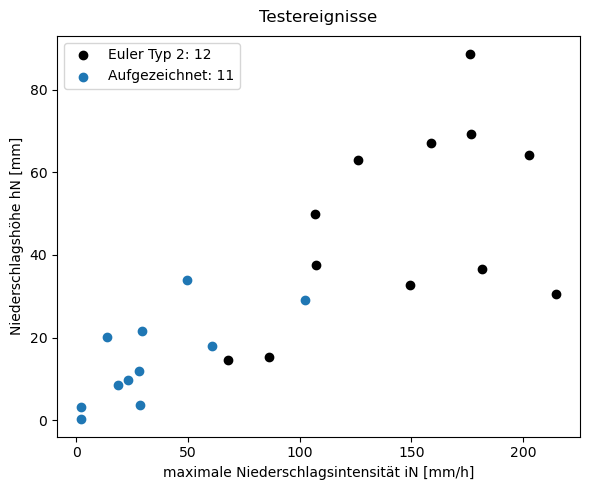

In [14]:
# Extract total precipitation and max intensity from seq_test
test_e2_precip = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']
test_e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']

test_measured_precip = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']
test_measured_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( test_e2_intensity, test_e2_precip,'o', color='black', label='Sample')
ax2.scatter(test_measured_intensity, test_measured_precip, marker='o',  label='Events')

ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(test_e2_precip)), 'Aufgezeichnet: {}'.format(len(test_measured_precip))])
plt.tight_layout()


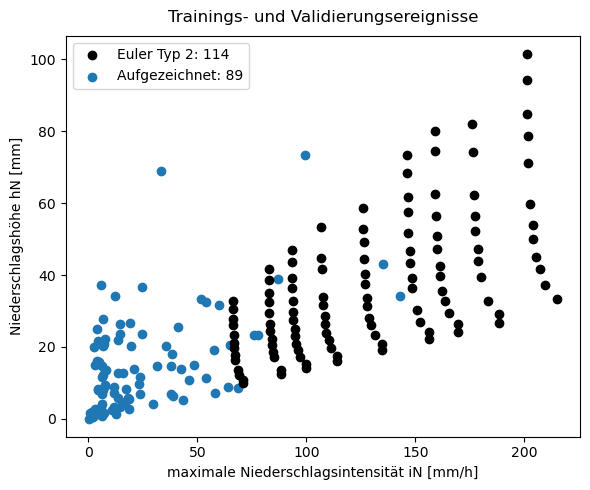

In [12]:
# Extract total precipitation and max intensity from seq_test
train_val_e2_precip = [obj[0]['total precipitation'] for obj in seq_train_val_trans if obj[0]['event type'] == 'Euler Typ 2']
train_val_e2_intensity = [obj[0]['max intensity'] for obj in seq_train_val_trans if obj[0]['event type'] == 'Euler Typ 2']

train_val_measured_precip = [obj[0]['total precipitation'] for obj in seq_train_val_trans if obj[0]['event type'] == 'Aufgezeichnet']
train_val_measured_intensity = [obj[0]['max intensity'] for obj in seq_train_val_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( train_val_e2_intensity, train_val_e2_precip,'o', color='black', label='Sample')
ax2.scatter(train_val_measured_intensity, train_val_measured_precip, marker='o',  label='Events')

ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Trainings- und Validierungsereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(train_val_e2_precip)), 'Aufgezeichnet: {}'.format(len(train_val_measured_precip))])
plt.tight_layout()


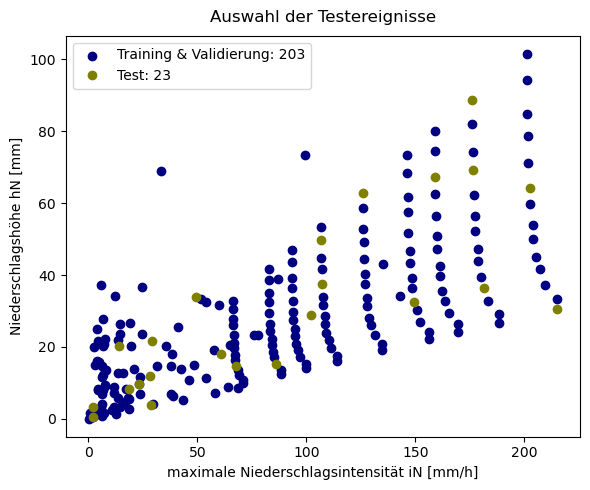

In [16]:
train_val_precip = train_val_e2_precip + train_val_measured_precip
train_val_intensity = train_val_e2_intensity + train_val_measured_intensity

test_precip = test_e2_precip + test_measured_precip
test_intensity = test_e2_intensity + test_measured_intensity

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.scatter(train_val_intensity, train_val_precip, marker='o', color='navy', label='Events')
ax2.plot( test_intensity, test_precip,'o', color='olive', label='Sample')

ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Auswahl der Testereignisse', pad=10)
ax2.legend(labels=['Training & Validierung: {}'.format(len(train_val_precip)), 'Test: {}'.format(len(test_precip))])
plt.tight_layout()

!!!!!!!!!!!!!!!!!!!!Nachfolgend nur relevant wenn keine Crossvalidation angewandt wird

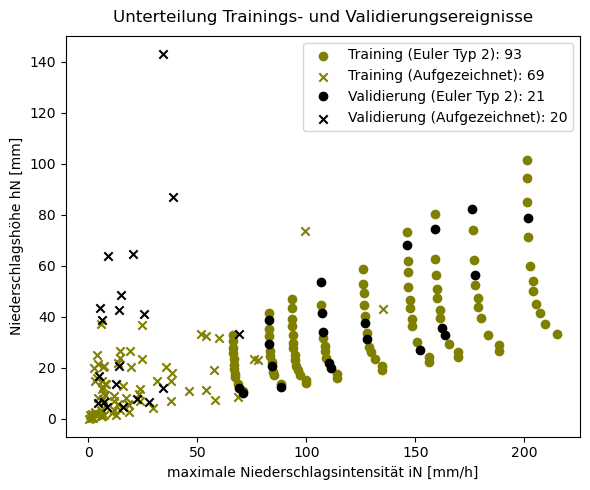

In [18]:

random_2 = 50 # 50,25 good
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=random_2)

seq_train, seq_train_trans = sequence_list(train_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                  out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
seq_val_train, seq_val_trans = sequence_list(val_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                  out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)

train_e2_precip = [obj[0]['total precipitation'] for obj in seq_train_trans if obj[0]['event type'] == 'Euler Typ 2']
train_e2_intensity = [obj[0]['max intensity'] for obj in seq_train_trans if obj[0]['event type'] == 'Euler Typ 2']

train_measured_precip = [obj[0]['total precipitation'] for obj in seq_train_trans if obj[0]['event type'] == 'Aufgezeichnet']
train_measured_intensity = [obj[0]['max intensity'] for obj in seq_train_trans if obj[0]['event type'] == 'Aufgezeichnet']

val_e2_precip = [obj[0]['total precipitation'] for obj in seq_val_trans if obj[0]['event type'] == 'Euler Typ 2']
val_e2_intensity = [obj[0]['max intensity'] for obj in seq_val_trans if obj[0]['event type'] == 'Euler Typ 2']

val_measured_precip = [obj[0]['total precipitation'] for obj in seq_val_trans if obj[0]['event type'] == 'Aufgezeichnet']
val_measured_intensity = [obj[0]['max intensity'] for obj in seq_val_trans if obj[0]['event type'] == 'Aufgezeichnet']


train_precip = [obj[0]['total precipitation'] for obj in seq_train_trans]
train_intensity = [obj[0]['max intensity'] for obj in seq_train_trans]

val_precip = [obj[0]['total precipitation'] for obj in seq_val_trans]
val_intensity = [obj[0]['max intensity'] for obj in seq_val_trans]

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.scatter(train_e2_intensity, train_e2_precip, marker='o', color='olive', label='Events')
ax2.scatter(train_measured_intensity, train_measured_precip, marker='x', color='olive', label='Events')
ax2.plot( val_e2_intensity, val_e2_precip,'o', color='Black', label='Sample')
ax2.scatter(val_measured_precip, val_measured_intensity, marker='x', color='Black', label='Sample')

ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Unterteilung Trainings- und Validierungsereignisse', pad=10)
ax2.legend(labels=['Training (Euler Typ 2): {}'.format(len(train_e2_intensity)), 'Training (Aufgezeichnet): {}'.format(len(train_measured_precip)), 
                   'Validierung (Euler Typ 2): {}'.format(len(val_e2_precip)), 'Validierung (Aufgezeichnet): {}'.format(len(val_measured_intensity))])
plt.tight_layout()